### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

### Подготовка

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [7]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords

from razdel import tokenize

import pymorphy2 

In [28]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [29]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
stopword_ru.append('nn')

In [30]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [31]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 24.4 s, sys: 171 ms, total: 24.6 s
Wall time: 24.8 s


In [32]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 42s, sys: 1.45 s, total: 4min 43s
Wall time: 4min 50s


А теперь в 3 строчки обучим нашу модель

In [33]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [34]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 35.7 s, sys: 1.91 s, total: 37.6 s
Wall time: 25.1 s


In [35]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [36]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.033020783),
 (20, 0.10938331),
 (21, 0.1868772),
 (22, 0.3286517),
 (24, 0.321028)]

In [37]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: сша гражданин ракета россия американский век технология
topic_1: вицепремьер годовой ндс звание спасать путешествовать козак
topic_2: млн рак снизить фильм продажа разместить клиент
topic_3: северный экипаж океан флот свидетель корея южный
topic_4: китай китайский остров применение лаборатория след рейтинг
topic_5: земля район день поверхность восток житель армия
topic_6: страдать продолжительность сон египетский перевод инвестировать рекорд
topic_7: проект фонд новый путин строительство первый россия
topic_8: украина млрд украинский средство банк бюджет сообщение
topic_9: ставка конкурс производитель метод врач явление пациент
topic_10: ребёнок женщина следствие родитель общество возраст взрослый
topic_11: научный франция доклад японский французский место активность
topic_12: военный наука россия москва сша управление помощь
topic_13: россия российский правительство глава власть решение документ
topic_14: снижение космос планета активность автор запуск подросток
topic_15: пог

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [38]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [39]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.0,0.171712,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.048355,0.000000,0.000000,0.000000,0.000000,0.069389
1,4896,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.528537,0.0,0.000000,0.000000,0.000000,0.000000,0.172098,0.276199
2,4897,0.0,0.0,0.033013,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.109383,0.186965,0.328592,0.000000,0.321008
3,4898,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.303385,0.000000,0.336771,0.046138,0.000000,0.072090
4,4899,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.753618,0.096434


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [40]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [41]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [42]:
doc_dict[293622]

array([0.        , 0.        , 0.119943  , 0.        , 0.        ,
       0.        , 0.        , 0.06199646, 0.        , 0.        ,
       0.11753032, 0.        , 0.07945862, 0.16909161, 0.        ,
       0.        , 0.09443586, 0.10955767, 0.        , 0.13056356,
       0.        , 0.10637249, 0.        , 0.        , 0.        ])

In [43]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [75]:
user_articles_list

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [44]:
get_user_embedding(user_articles_list)

array([0.11526193, 0.        , 0.        , 0.00454638, 0.        ,
       0.00601112, 0.        , 0.05797376, 0.03731704, 0.03469096,
       0.04891881, 0.01048095, 0.14834737, 0.15983814, 0.0214415 ,
       0.        , 0.05992622, 0.03277661, 0.        , 0.0118799 ,
       0.05837773, 0.04703196, 0.0727872 , 0.05819009, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [45]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.017758,0.0,0.045174,0.000000,0.0,0.055596,0.000000,0.101300,0.136140,...,0.017835,0.083272,0.022201,0.0,0.032412,0.006368,0.047594,0.003217,0.038709,0.020361
1,u108690,0.056361,0.0,0.025094,0.000000,0.0,0.015249,0.003459,0.029410,0.135413,...,0.004581,0.012111,0.022681,0.0,0.031991,0.035130,0.147394,0.068009,0.046824,0.000000
2,u108339,0.024188,0.0,0.004155,0.001845,0.0,0.063707,0.000000,0.018399,0.039238,...,0.033536,0.035568,0.057072,0.0,0.006108,0.073976,0.082639,0.078367,0.018390,0.008014


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [46]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [47]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.017758,0.0,0.045174,0.000000,0.0,0.055596,0.000000,0.101300,0.136140,...,0.083272,0.022201,0.0,0.032412,0.006368,0.047594,0.003217,0.038709,0.020361,0
1,u108690,0.056361,0.0,0.025094,0.000000,0.0,0.015249,0.003459,0.029410,0.135413,...,0.012111,0.022681,0.0,0.031991,0.035130,0.147394,0.068009,0.046824,0.000000,1
2,u108339,0.024188,0.0,0.004155,0.001845,0.0,0.063707,0.000000,0.018399,0.039238,...,0.035568,0.057072,0.0,0.006108,0.073976,0.082639,0.078367,0.018390,0.008014,1


In [76]:
X

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.068129,0.000000,0.139904,0.000000,0.000000,0.233034,0.000000,0.287768,0.771424,...,0.298356,0.109558,0.000000,0.130564,0.038209,0.106372,0.019302,0.186760,0.122166,0
1,u108690,0.242743,0.000000,0.071392,0.000000,0.000000,0.054459,0.020754,0.067135,0.403350,...,0.054016,0.119526,0.000000,0.066166,0.121305,0.290499,0.144666,0.149629,0.000000,1
2,u108339,0.109683,0.000000,0.024930,0.011070,0.000000,0.195162,0.000000,0.091926,0.111624,...,0.077122,0.149907,0.000000,0.036646,0.177030,0.168311,0.149335,0.069949,0.034019,1
3,u101138,0.291656,0.000000,0.126381,0.026799,0.262529,0.148372,0.000000,0.038212,0.265714,...,0.071800,0.000000,0.000000,0.158696,0.000000,0.649532,0.098618,0.026354,0.419720,0
4,u108248,0.070527,0.000000,0.032787,0.012961,0.000000,0.332582,0.032570,0.133308,0.315072,...,0.135826,0.052357,0.000000,0.315092,0.081898,0.176508,0.211006,0.168122,0.024348,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,u107463,0.138228,0.000000,0.019322,0.013722,0.000000,0.149517,0.011770,0.090609,0.174349,...,0.202323,0.208109,0.000000,0.000000,0.153208,0.169421,0.179608,0.160731,0.026762,0
7996,u101241,0.095041,0.000000,0.529630,0.000000,0.058976,0.099480,0.000000,0.062675,0.000000,...,0.058076,0.352539,0.000000,0.340653,0.216072,0.417033,0.052324,0.184375,0.604489,0
7997,u106486,0.231317,0.023602,0.019144,0.019258,0.015193,0.087877,0.025466,0.026890,0.178127,...,0.012011,0.158753,0.000000,0.093400,0.275103,0.197060,0.139616,0.492638,0.000000,0
7998,u102220,0.020870,0.026174,0.604080,0.137390,0.241761,0.230622,0.000000,0.115665,0.110526,...,0.000000,0.252130,0.080898,0.797434,0.188787,0.343178,0.071868,0.000000,0.249597,0


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [49]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [50]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [51]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.14842393, 0.04495045, 0.38790265, 0.10199429, 0.02797726,
       0.11948801, 0.09107888, 0.09781467, 0.05820374, 0.10010759])

In [52]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.263550, F-Score=0.723, Precision=0.680, Recall=0.771


In [56]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1666   89]
 [  57  188]]


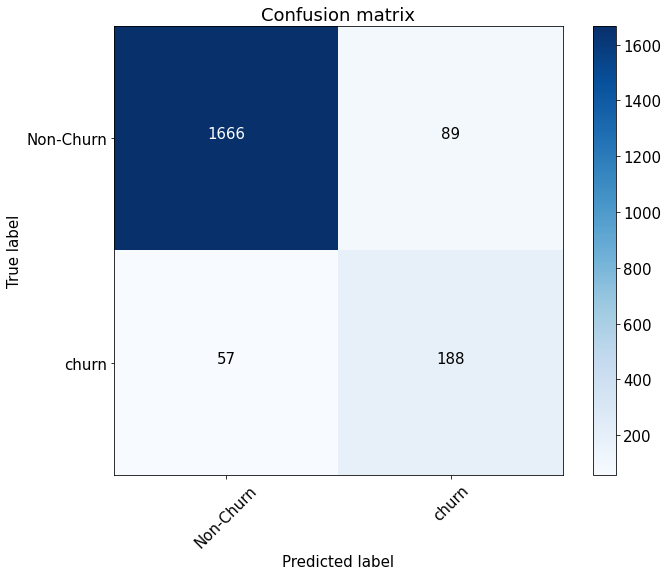

In [57]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [58]:
roc_auc_score(y_test, preds)

0.9614210128495843

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

### 3. Повторить п.2, но используя уже не медиану, а max

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_user_embedding(user_articles_list, method='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if method == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif method == 'max':
        user_vector = np.max(user_vector, 0)
    elif method == 'median':
        user_vector = np.median(user_vector, 0)
    return user_vector

In [82]:
logreg = LogisticRegression()
results = dict()
for method in ['mean', 'median', 'max']:
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, method), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    X = pd.merge(user_embeddings, target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    method_f_score = fscore[ix]
    method_precision_score = precision[ix]
    method_recall_score = recall[ix]
    method_roc_auc_score = roc_auc_score(y_test, preds)
    results[method] = [method_f_score, method_precision_score, method_recall_score, method_roc_auc_score]

In [83]:
results = pd.DataFrame(results, index = ['f1-score', 'precision', 'recall', 'roc_auc_score'])
results

,mean,median,max
f1-score,0.722753,0.832714,0.781784
precision,0.679856,0.764505,0.730496
recall,0.771429,0.914286,0.840816
roc_auc_score,0.961421,0.982920,0.977573


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или иной способ оказался эффективнее остальных

Медиана отработала лучше всего, т.к. более устойчива к выбросам, чем усреднение и использование максимальных значений, и лучше "характеризует" пользователя.